In [607]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error
from prophet import Prophet

In [608]:
chicago_df = pd.read_csv('Crimes.csv')
# Violent crimes, homicide, batterey, assault, robbery, criminal sexual assault
chicago_df = chicago_df[chicago_df['Primary Type'].isin(['HOMICIDE', 'BATTERY', 'ASSAULT', 'ROBBERY', 'CRIMINAL SEXUAL ASSAULT'])]

<Axes: >

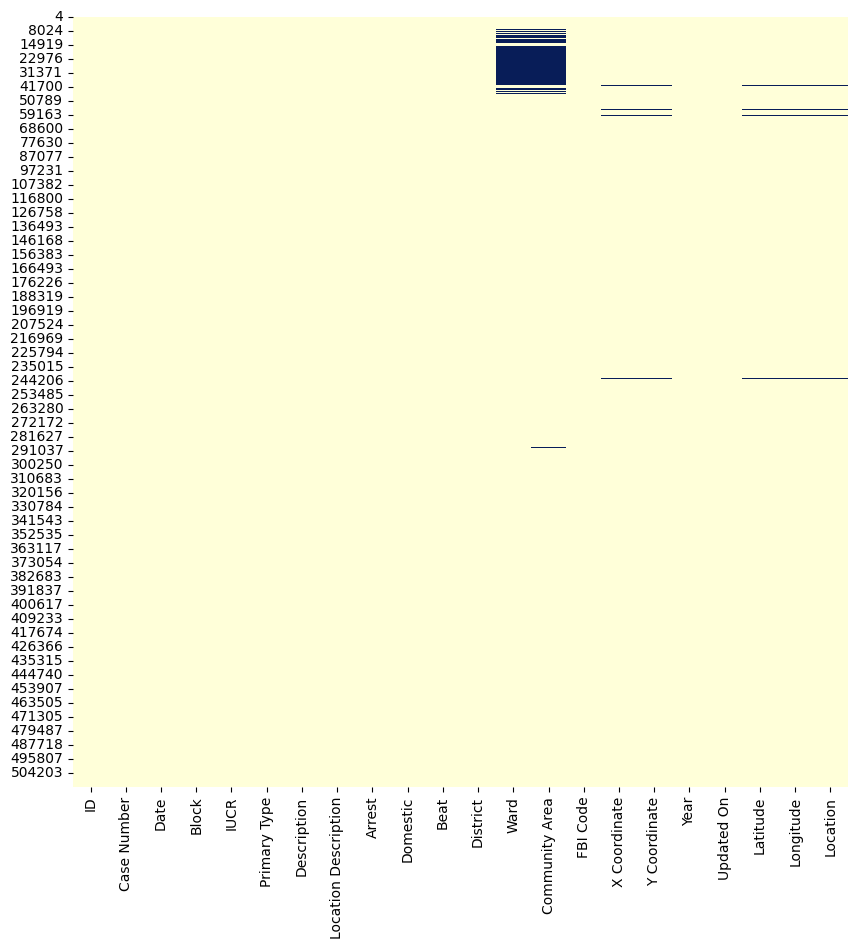

In [609]:
# Plot missing information 
plt.figure(figsize = (10,10))
sns.heatmap(chicago_df.isnull(), cbar=False, cmap = 'YlGnBu')

In [610]:
# Drop some of the columns we know we will not use for this prediction
chicago_df.drop(['ID',
                 'Case Number',
                 'IUCR',
                 'X Coordinate',
                 'Y Coordinate',
                 'Updated On',
                 'Year',
                 'FBI Code',
                 'Beat',
                 'Ward',
                 'Community Area',
                 'Location',
                 'District',
                 'Latitude',
                 'Longitude' ], inplace = True, axis = 1)

In [611]:
chicago_df.head(10)


Date                     Block Primary Type  \
4   09/08/2021 04:45:00 PM       047XX W HARRISON ST     HOMICIDE   
8   09/06/2023 02:45:00 PM       031XX W FILLMORE ST      BATTERY   
9   09/06/2023 11:45:00 AM        010XX N PULASKI RD      BATTERY   
13  09/06/2023 04:00:00 PM      011XX S ST LOUIS AVE      BATTERY   
14  09/06/2023 06:00:00 AM       0000X N HAMLIN BLVD      BATTERY   
16  09/06/2023 12:21:00 AM       035XX W FLOURNOY ST      ASSAULT   
18  09/06/2023 09:00:00 PM     033XX W ARTHINGTON ST      ASSAULT   
19  09/06/2023 01:01:00 PM         042XX W THOMAS ST      ROBBERY   
20  09/06/2023 09:00:00 PM  006XX N CENTRAL PARK AVE      BATTERY   
23  09/06/2023 11:50:00 PM      031XX W LEXINGTON ST      BATTERY   

                                          Description Location Description  \
4                                 FIRST DEGREE MURDER             CAR WASH   
8                             DOMESTIC BATTERY SIMPLE             SIDEWALK   
9                                              SIMPLE    CONVENIENCE STORE   
13  AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...                ALLEY   
14                            DOMESTIC BATTERY SIMPLE            APARTMENT   
16                                             SIMPLE            APARTMENT   
18            AGGRAVATED - KNIFE / CUTTING INSTRUMENT            RESIDENCE   
19                     AGGRAVATED VEHICULAR HIJACKING               STREET   
20                            DOMESTIC BATTERY SIMPLE               STREET   
23  AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS ...            APARTMENT   

    Arrest  Domestic  
4     True     False  
8    False      True  
9    False     False  
13   False      True  
14   False      True  
16   False      True  
18   False      True  
19   False     False  
20   False      True  
23   False      True

In [612]:
chicago_df.Date = pd.to_datetime(chicago_df.Date, format = '%m/%d/%Y %I:%M:%S %p')

In [613]:
chicago_df.index = pd.DatetimeIndex(chicago_df.Date)
chicago_df.head(3)

Date                Block Primary Type  \
Date                                                                        
2021-09-08 16:45:00 2021-09-08 16:45:00  047XX W HARRISON ST     HOMICIDE   
2023-09-06 14:45:00 2023-09-06 14:45:00  031XX W FILLMORE ST      BATTERY   
2023-09-06 11:45:00 2023-09-06 11:45:00   010XX N PULASKI RD      BATTERY   

                                 Description Location Description  Arrest  \
Date                                                                        
2021-09-08 16:45:00      FIRST DEGREE MURDER             CAR WASH    True   
2023-09-06 14:45:00  DOMESTIC BATTERY SIMPLE             SIDEWALK   False   
2023-09-06 11:45:00                   SIMPLE    CONVENIENCE STORE   False   

                     Domestic  
Date                           
2021-09-08 16:45:00     False  
2023-09-06 14:45:00      True  
2023-09-06 11:45:00     False

In [614]:
chicago_df['Primary Type'].value_counts()


Primary Type
BATTERY                    102071
ASSAULT                     32095
ROBBERY                     22301
HOMICIDE                     1398
CRIMINAL SEXUAL ASSAULT       490
Name: count, dtype: int64

In [615]:
chicago_df['Primary Type'].value_counts().iloc[:15]

Primary Type
BATTERY                    102071
ASSAULT                     32095
ROBBERY                     22301
HOMICIDE                     1398
CRIMINAL SEXUAL ASSAULT       490
Name: count, dtype: int64

In [616]:
# How many crimes occured in a year
chicago_df.resample('Y').size()

Date
2001-12-31    8920
2002-12-31    9498
2003-12-31    8925
2004-12-31    8652
2005-12-31    8409
2006-12-31    7921
2007-12-31    7880
2008-12-31    8084
2009-12-31    7395
2010-12-31    7004
2011-12-31    6694
2012-12-31    6374
2013-12-31    5809
2014-12-31    5573
2015-12-31    5808
2016-12-31    6346
2017-12-31    6123
2018-12-31    6290
2019-12-31    5752
2020-12-31    5368
2021-12-31    4990
2022-12-31    4702
2023-12-31    5173
2024-12-31     665
Freq: A-DEC, dtype: int64

Text(0, 0.5, 'Number of Crimes')

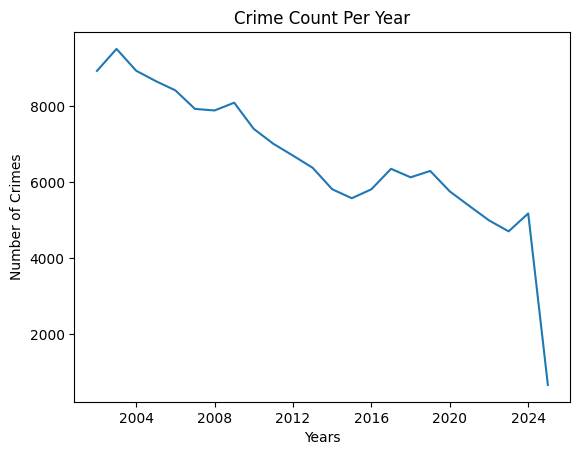

In [617]:
# Plot crimes per year
plt.plot(chicago_df.resample('Y').size())
plt.title('Crime Count Per Year')
plt.xlabel('Years')
plt.ylabel('Number of Crimes')


Text(0, 0.5, 'Number of Crimes')

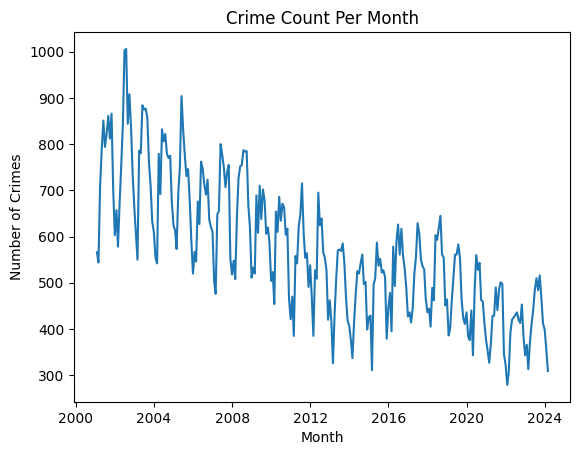

In [618]:
# Plot crimes per Month
plt.plot(chicago_df.resample('M').size())
plt.title('Crime Count Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

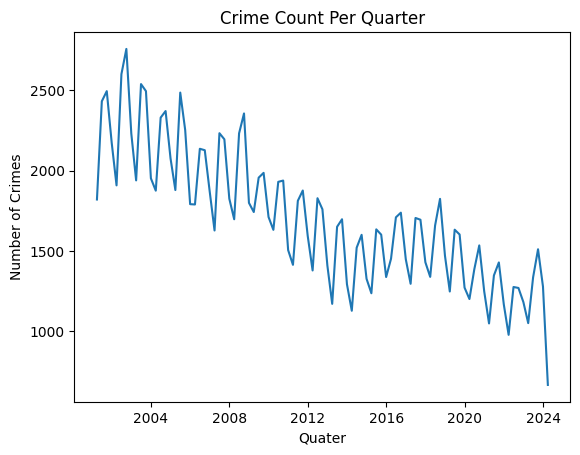

In [619]:
# Plot crimes per Quarter
plt.plot(chicago_df.resample('Q').size())
plt.title('Crime Count Per Quarter')
plt.xlabel('Quater')
plt.ylabel('Number of Crimes')

In [620]:
chicago_prophet = chicago_df.resample('D').size().reset_index()

chicago_prophet.columns = ['Date', 'Crime Count']
# Remove dates after 2023 and before 2015
chicago_prophet = chicago_prophet[chicago_prophet['Date'].dt.year < 2024]
chicago_prophet = chicago_prophet[chicago_prophet['Date'].dt.year > 2015]
chicago_prophet.head()

Date  Crime Count
5478 2016-01-01           27
5479 2016-01-02           10
5480 2016-01-03           17
5481 2016-01-04           10
5482 2016-01-05           16

In [621]:
# rename Date time to DS and prediction to y for final Prophet training

chicago_prophet_df_final = chicago_prophet.rename(columns = {'Date':'ds','Crime Count':'y'})

In [622]:
chicago_prophet_df_final

ds   y
5478 2016-01-01  27
5479 2016-01-02  10
5480 2016-01-03  17
5481 2016-01-04  10
5482 2016-01-05  16
...         ...  ..
8395 2023-12-27   9
8396 2023-12-28   4
8397 2023-12-29  10
8398 2023-12-30  20
8399 2023-12-31  13

[2922 rows x 2 columns]

# Regular Prophet Model

In [623]:
m = Prophet()
m.fit(chicago_prophet_df_final)

02:25:27 - cmdstanpy - INFO - Chain [1] start processing
02:25:27 - cmdstanpy - INFO - Chain [1] done processing


In [624]:
future =m.make_future_dataframe(periods = 720)
forecast = m.predict(future)

In [625]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2016-01-01  17.536880    9.729256   20.285013    17.536880    17.536880   
1    2016-01-02  17.536021   11.017231   22.146948    17.536021    17.536021   
2    2016-01-03  17.535161   11.203919   21.704446    17.535161    17.535161   
3    2016-01-04  17.534302    9.274734   19.770637    17.534302    17.534302   
4    2016-01-05  17.533442    8.773151   19.445566    17.533442    17.533442   
...         ...        ...         ...         ...          ...          ...   
3637 2025-12-16  15.969720    7.116463   17.792447    15.494718    16.490931   
3638 2025-12-17  15.971974    7.734559   18.364734    15.496296    16.494417   
3639 2025-12-18  15.974229    6.949959   17.972992    15.497616    16.497903   
3640 2025-12-19  15.976483    8.305310   19.056697    15.498936    16.501389   
3641 2025-12-20  15.978738    9.231958   20.168861    15.500222    16.504876   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0          -2.729681             -2.729681             -2.729681 -0.250710   
1          -1.186185             -1.186185             -1.186185  1.298202   
2          -1.066756             -1.066756             -1.066756  1.428476   
3          -3.036192             -3.036192             -3.036192 -0.524115   
4          -3.271747             -3.271747             -3.271747 -0.736442   
...              ...                   ...                   ...       ...   
3637       -3.121389             -3.121389             -3.121389 -0.736442   
3638       -2.755217             -2.755217             -2.755217 -0.332471   
3639       -3.337235             -3.337235             -3.337235 -0.882940   
3640       -2.730186             -2.730186             -2.730186 -0.250710   
3641       -1.200164             -1.200164             -1.200164  1.298202   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0        -0.250710     -0.250710 -2.478971     -2.478971     -2.478971   
1         1.298202      1.298202 -2.484387     -2.484387     -2.484387   
2         1.428476      1.428476 -2.495232     -2.495232     -2.495232   
3        -0.524115     -0.524115 -2.512077     -2.512077     -2.512077   
4        -0.736442     -0.736442 -2.535306     -2.535306     -2.535306   
...            ...           ...       ...           ...           ...   
3637     -0.736442     -0.736442 -2.384947     -2.384947     -2.384947   
3638     -0.332471     -0.332471 -2.422745     -2.422745     -2.422745   
3639     -0.882940     -0.882940 -2.454295     -2.454295     -2.454295   
3640     -0.250710     -0.250710 -2.479476     -2.479476     -2.479476   
3641      1.298202      1.298202 -2.498366     -2.498366     -2.498366   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
3637                   0.0                         0.0   
3638                   0.0                         0.0   
3639                   0.0                         0.0   
3640                   0.0                         0.0   
3641                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
0                            0.0  14.807199  
1                            0.0  16.349836  
2                            0.0  16.468405  
3                            0.0  14.498110  
4                            0.0  14.261695  
...                          ...        ...  
3637                         0.0  12.848331  
3638                         0.0  13.216757  
3639                         0.0  12.636994  
3640                         0.0  13.246298  
3641                   

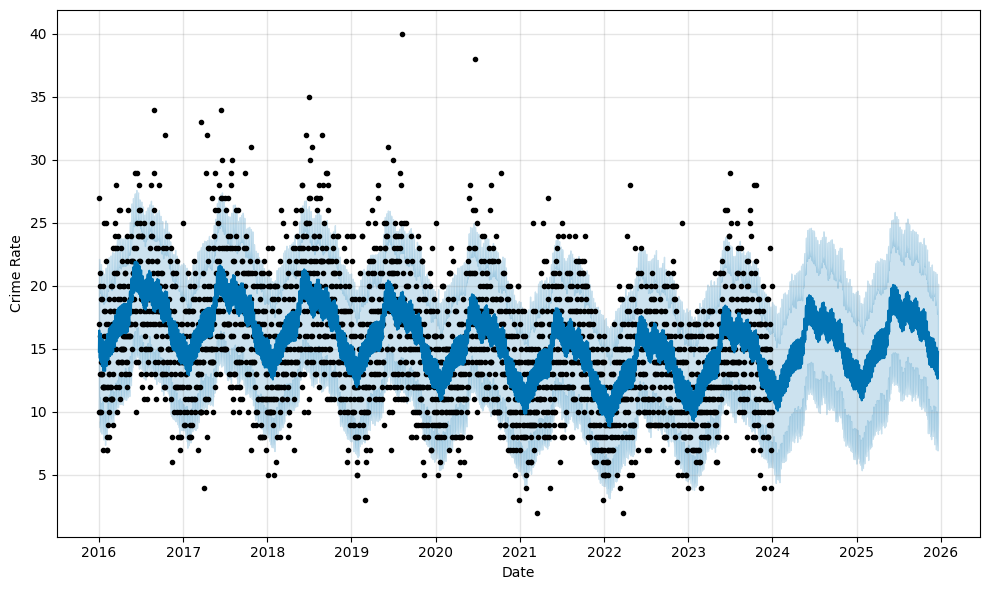

In [626]:
figure = m.plot(forecast, xlabel = 'Date', ylabel = 'Crime Rate')

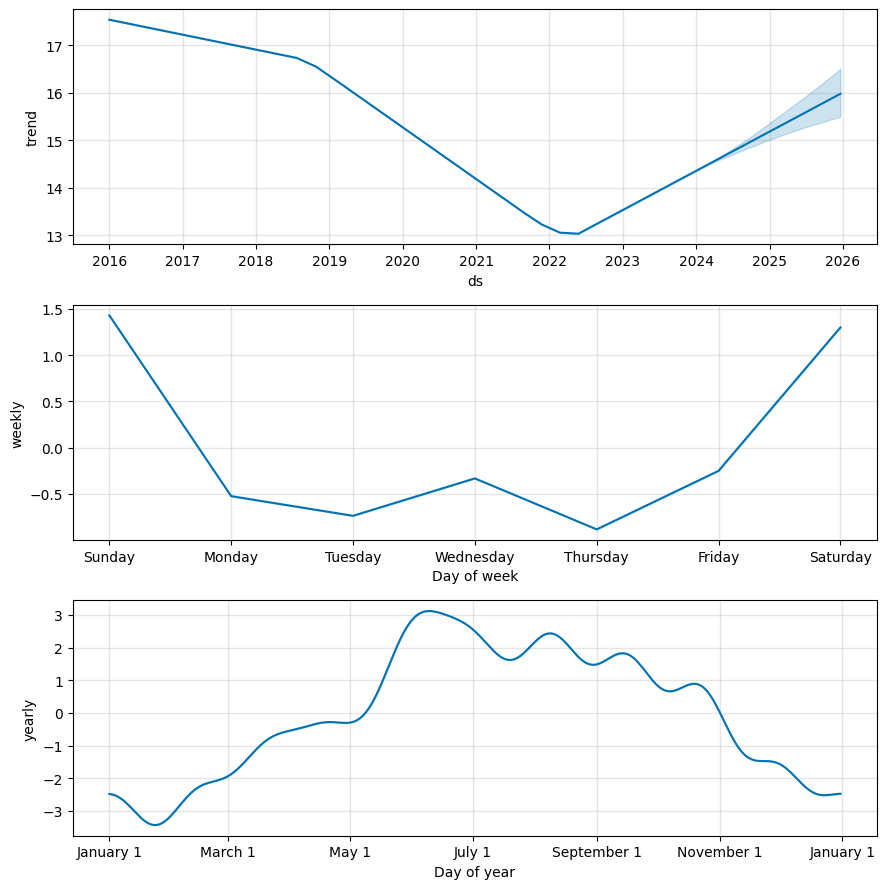

In [627]:
figure = m.plot_components(forecast)

### Findings
  - **Overall**: Trending down
  - **Weekly**: Tuesday-Friday are top days for crime
  - **Yearly**: Warmer months = more crime

In [628]:
# Make a forecast_final joined with the original dataframe
forecast_final = forecast.set_index('ds')[['yhat']].join(chicago_prophet_df_final.set_index('ds').y).reset_index()

# Remove NaN values in y
forecast_final.dropna(subset = ['y'], inplace = True)

# Calculate error and uncertainty
forecast_final['error'] = forecast_final['y'] - forecast_final['yhat']
forecast_final['uncertainty'] = forecast_final['yhat']

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(forecast_final['yhat'],forecast_final['y'])
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = sqrt(int(mean_squared_error(forecast_final['yhat'],forecast_final['y'])))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

Mean Absolute Error (MAE): 3.36
Median Absolute Error (MedAE): 2.84
Mean Squared Error (MSE): 17.87
Root Mean Squared Error (RMSE): 4.12
Mean Absolute Percentage Error (MAPE): 0.22 %


# Including Lockdowns as Holidays

In [629]:
# Include 2020 lockdowns
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

holiday         ds  lower_window   ds_upper  upper_window
0  lockdown_1 2020-03-21             0 2020-06-06            77
1  lockdown_2 2020-07-09             0 2020-10-27           110
2  lockdown_3 2021-02-13             0 2021-02-17             4
3  lockdown_4 2021-05-28             0 2021-06-10            13

02:25:32 - cmdstanpy - INFO - Chain [1] start processing
02:25:34 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Lockdowns as one-off holidays')

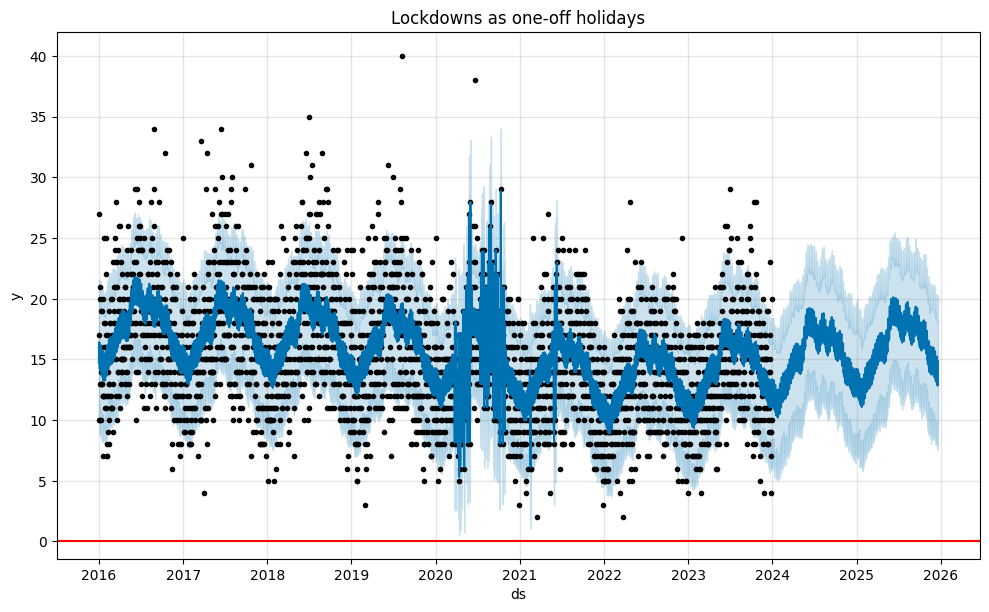

In [630]:
m2 = Prophet(holidays=lockdowns)
m2 = m2.fit(chicago_prophet_df_final)
future2 = m2.make_future_dataframe(periods=720)
forecast2 = m2.predict(future2)

m2.plot(forecast2)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays')


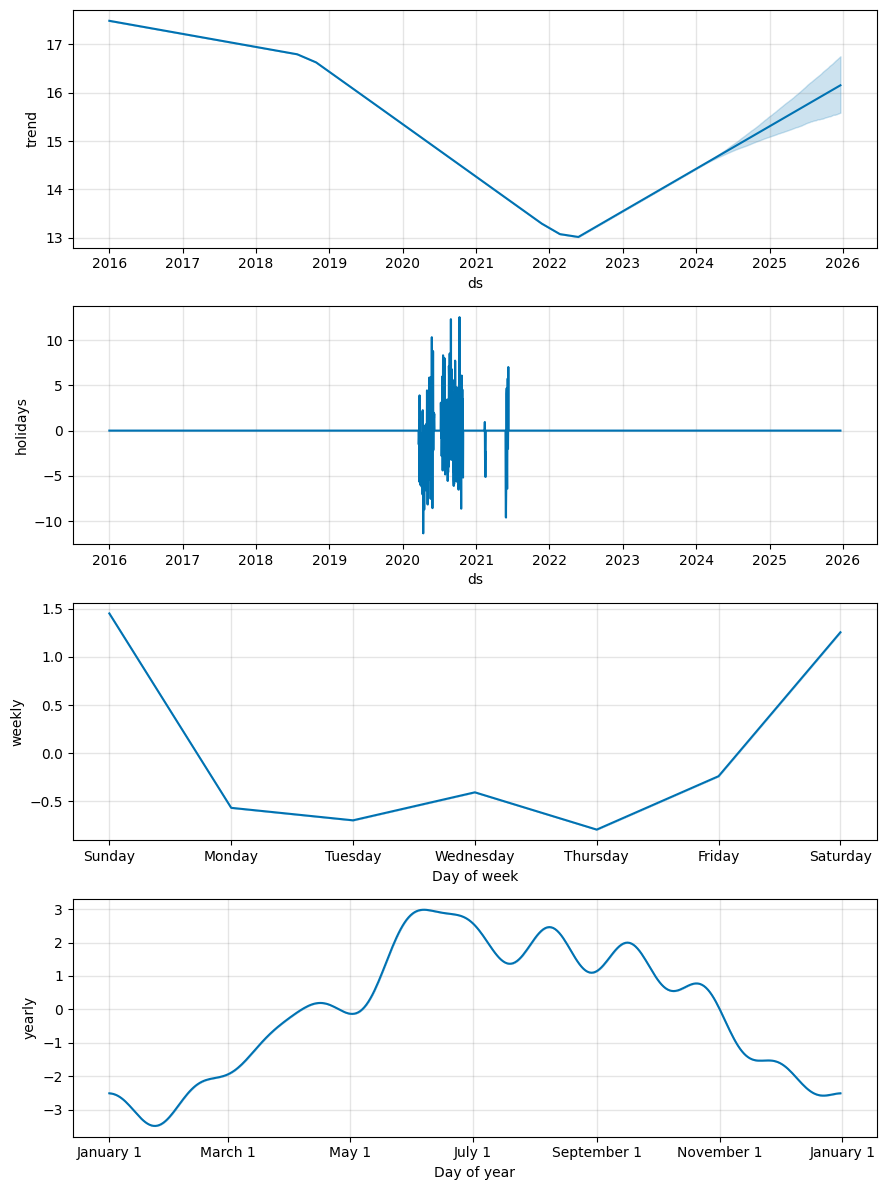

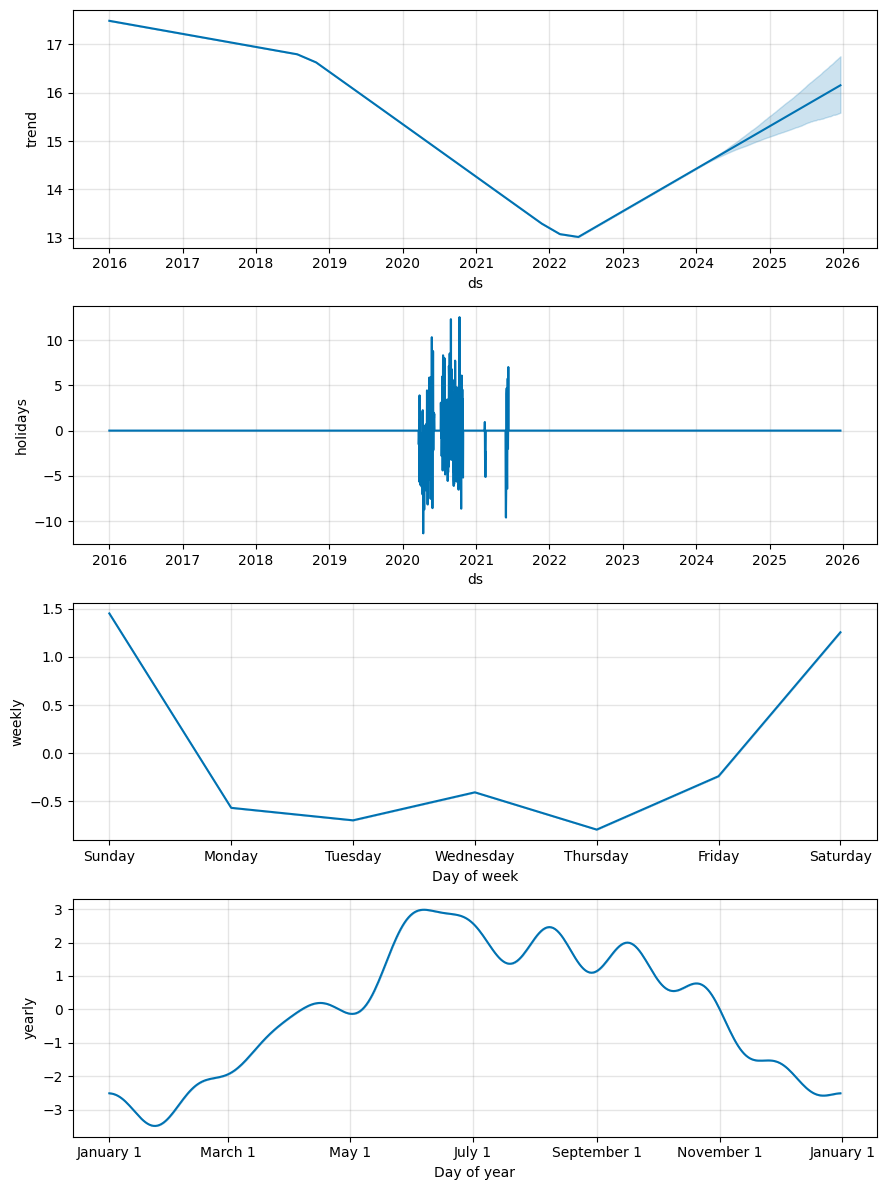

In [631]:
m2.plot_components(forecast2)

In [632]:
# Make a forecast_final joined with the original dataframe
forecast_final = forecast2.set_index('ds')[['yhat']].join(chicago_prophet_df_final.set_index('ds').y).reset_index()

# Remove NaN values in y
forecast_final.dropna(subset = ['y'], inplace = True)

# Calculate error and uncertainty
forecast_final['error'] = forecast_final['y'] - forecast_final['yhat']
forecast_final['uncertainty'] = forecast_final['yhat']

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(forecast_final['yhat'],forecast_final['y'])
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = sqrt(int(mean_squared_error(forecast_final['yhat'],forecast_final['y'])))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

Mean Absolute Error (MAE): 3.13
Median Absolute Error (MedAE): 2.57
Mean Squared Error (MSE): 16.55
Root Mean Squared Error (RMSE): 4.0
Mean Absolute Percentage Error (MAPE): 0.21 %


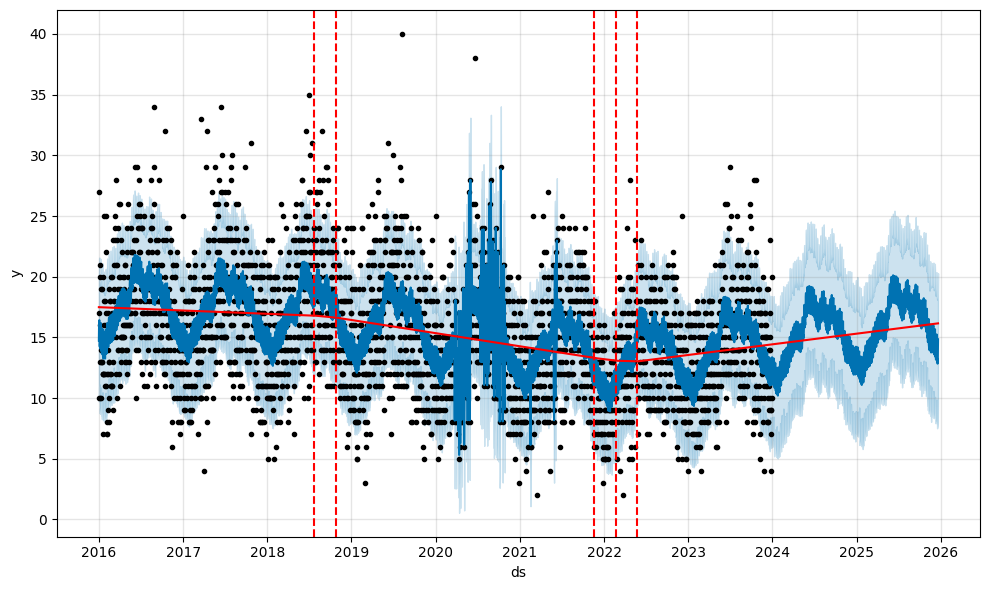

In [633]:
from prophet.plot import add_changepoints_to_plot
fig = m2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m2, forecast2)

# Pre-Covid / Post Covid

In [634]:
df2 = chicago_prophet_df_final.copy()
df2['pre_covid'] = pd.to_datetime(df2['ds']) < pd.to_datetime('2020-03-21')
df2['post_covid'] = ~df2['pre_covid']
df2['during_lockdown_1'] = (pd.to_datetime(df2['ds']) >= pd.to_datetime('2020-03-21')) & (pd.to_datetime(df2['ds']) <= pd.to_datetime('2020-06-06'))
df2['during_lockdown_2'] = (pd.to_datetime(df2['ds']) >= pd.to_datetime('2020-07-09')) & (pd.to_datetime(df2['ds']) <= pd.to_datetime('2020-10-27'))
df2['during_lockdown_3'] = (pd.to_datetime(df2['ds']) >= pd.to_datetime('2021-02-13')) & (pd.to_datetime(df2['ds']) <= pd.to_datetime('2021-02-17'))
df2['during_lockdown_4'] = (pd.to_datetime(df2['ds']) >= pd.to_datetime('2021-05-28')) & (pd.to_datetime(df2['ds']) <= pd.to_datetime('2021-06-10'))

In [635]:
lockdowns

holiday         ds  lower_window   ds_upper  upper_window
0  lockdown_1 2020-03-21             0 2020-06-06            77
1  lockdown_2 2020-07-09             0 2020-10-27           110
2  lockdown_3 2021-02-13             0 2021-02-17             4
3  lockdown_4 2021-05-28             0 2021-06-10            13

In [636]:
m4 = Prophet(holidays=lockdowns, weekly_seasonality=False)

In [637]:
m4.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m4.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
)
m4.add_seasonality(
    name='weekly_during_lockdown_1',
    period=7,
    fourier_order=3,
    condition_name='during_lockdown_1',
)
m4.add_seasonality(
    name='weekly_during_lockdown_2',
    period=7,
    fourier_order=3,
    condition_name='during_lockdown_2',
)
m4.add_seasonality(
    name='weekly_during_lockdown_3',
    period=7,
    fourier_order=3,
    condition_name='during_lockdown_3',
)
m4.add_seasonality(
    name='weekly_during_lockdown_4',
    period=7,
    fourier_order=3,
    condition_name='during_lockdown_4',
)

In [638]:
m4 = m4.fit(df2)

02:25:41 - cmdstanpy - INFO - Chain [1] start processing
02:25:43 - cmdstanpy - INFO - Chain [1] done processing


In [639]:
future4 = m4.make_future_dataframe(periods=365)
future4['pre_covid'] = pd.to_datetime(future4['ds']) < pd.to_datetime('2020-03-21')
future4['post_covid'] = ~future4['pre_covid']
future4['during_lockdown_1'] = (pd.to_datetime(future4['ds']) >= pd.to_datetime('2020-03-21')) & (pd.to_datetime(future4['ds']) <= pd.to_datetime('2020-06-06'))
future4['during_lockdown_2'] = (pd.to_datetime(future4['ds']) >= pd.to_datetime('2020-07-09')) & (pd.to_datetime(future4['ds']) <= pd.to_datetime('2020-10-27'))
future4['during_lockdown_3'] = (pd.to_datetime(future4['ds']) >= pd.to_datetime('2021-02-13')) & (pd.to_datetime(future4['ds']) <= pd.to_datetime('2021-02-17'))
future4['during_lockdown_4'] = (pd.to_datetime(future4['ds']) >= pd.to_datetime('2021-05-28')) & (pd.to_datetime(future4['ds']) <= pd.to_datetime('2021-06-10'))

In [640]:
forecast4 = m4.predict(future4)

Text(0.5, 1.0, 'Lockdowns as one-off holidays + Conditional weekly seasonality')

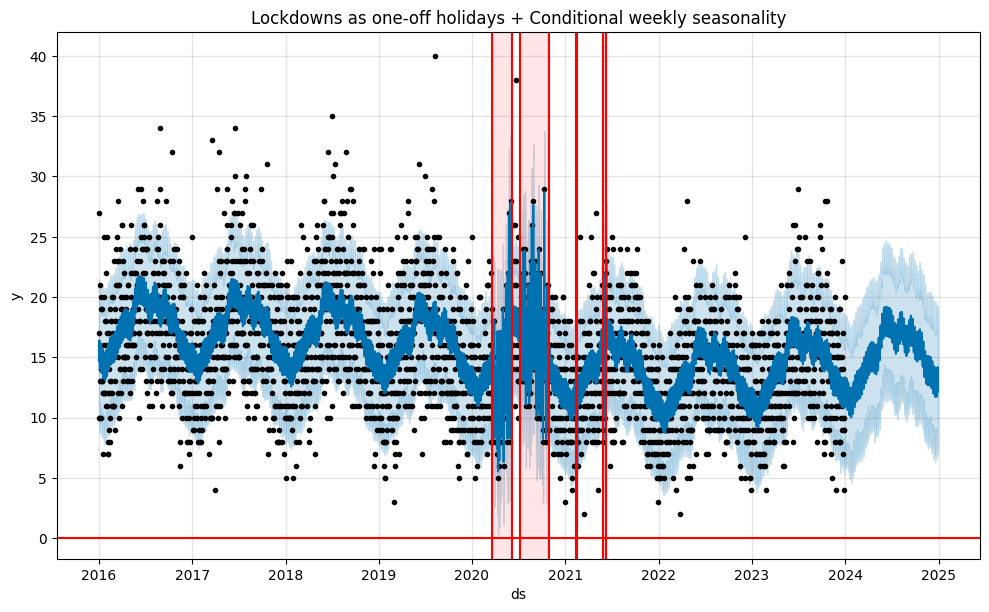

In [641]:
m4.plot(forecast4)
plt.axhline(y=0, color='red')
# Add Pre Covid line
plt.axvline(x=pd.to_datetime('2020-03-21'), color='red')
# Add Post Covid line
plt.axvline(x=pd.to_datetime('2020-06-06'), color='red')
# Add Lockdown 2 line
plt.axvline(x=pd.to_datetime('2020-07-09'), color='red')
# Add Lockdown 3 line
plt.axvline(x=pd.to_datetime('2020-10-27'), color='red')
# Add Lockdown 4 line
plt.axvline(x=pd.to_datetime('2021-02-13'), color='red')
# Add lockdown 5 line
plt.axvline(x=pd.to_datetime('2021-02-17'), color='red')
# Add lockdown 6 line
plt.axvline(x=pd.to_datetime('2021-05-28'), color='red')
# Add lockdown 7 line
plt.axvline(x=pd.to_datetime('2021-06-10'), color='red')
# Shade in between each
plt.axvspan(pd.to_datetime('2020-03-21'), pd.to_datetime('2020-06-06'), color='red', alpha=0.1)
plt.axvspan(pd.to_datetime('2020-07-09'), pd.to_datetime('2020-10-27'), color='red', alpha=0.1)
plt.axvspan(pd.to_datetime('2021-02-13'), pd.to_datetime('2021-02-17'), color='red', alpha=0.1)
plt.axvspan(pd.to_datetime('2021-05-28'), pd.to_datetime('2021-06-10'), color='red', alpha=0.1)

plt.title('Lockdowns as one-off holidays + Conditional weekly seasonality')

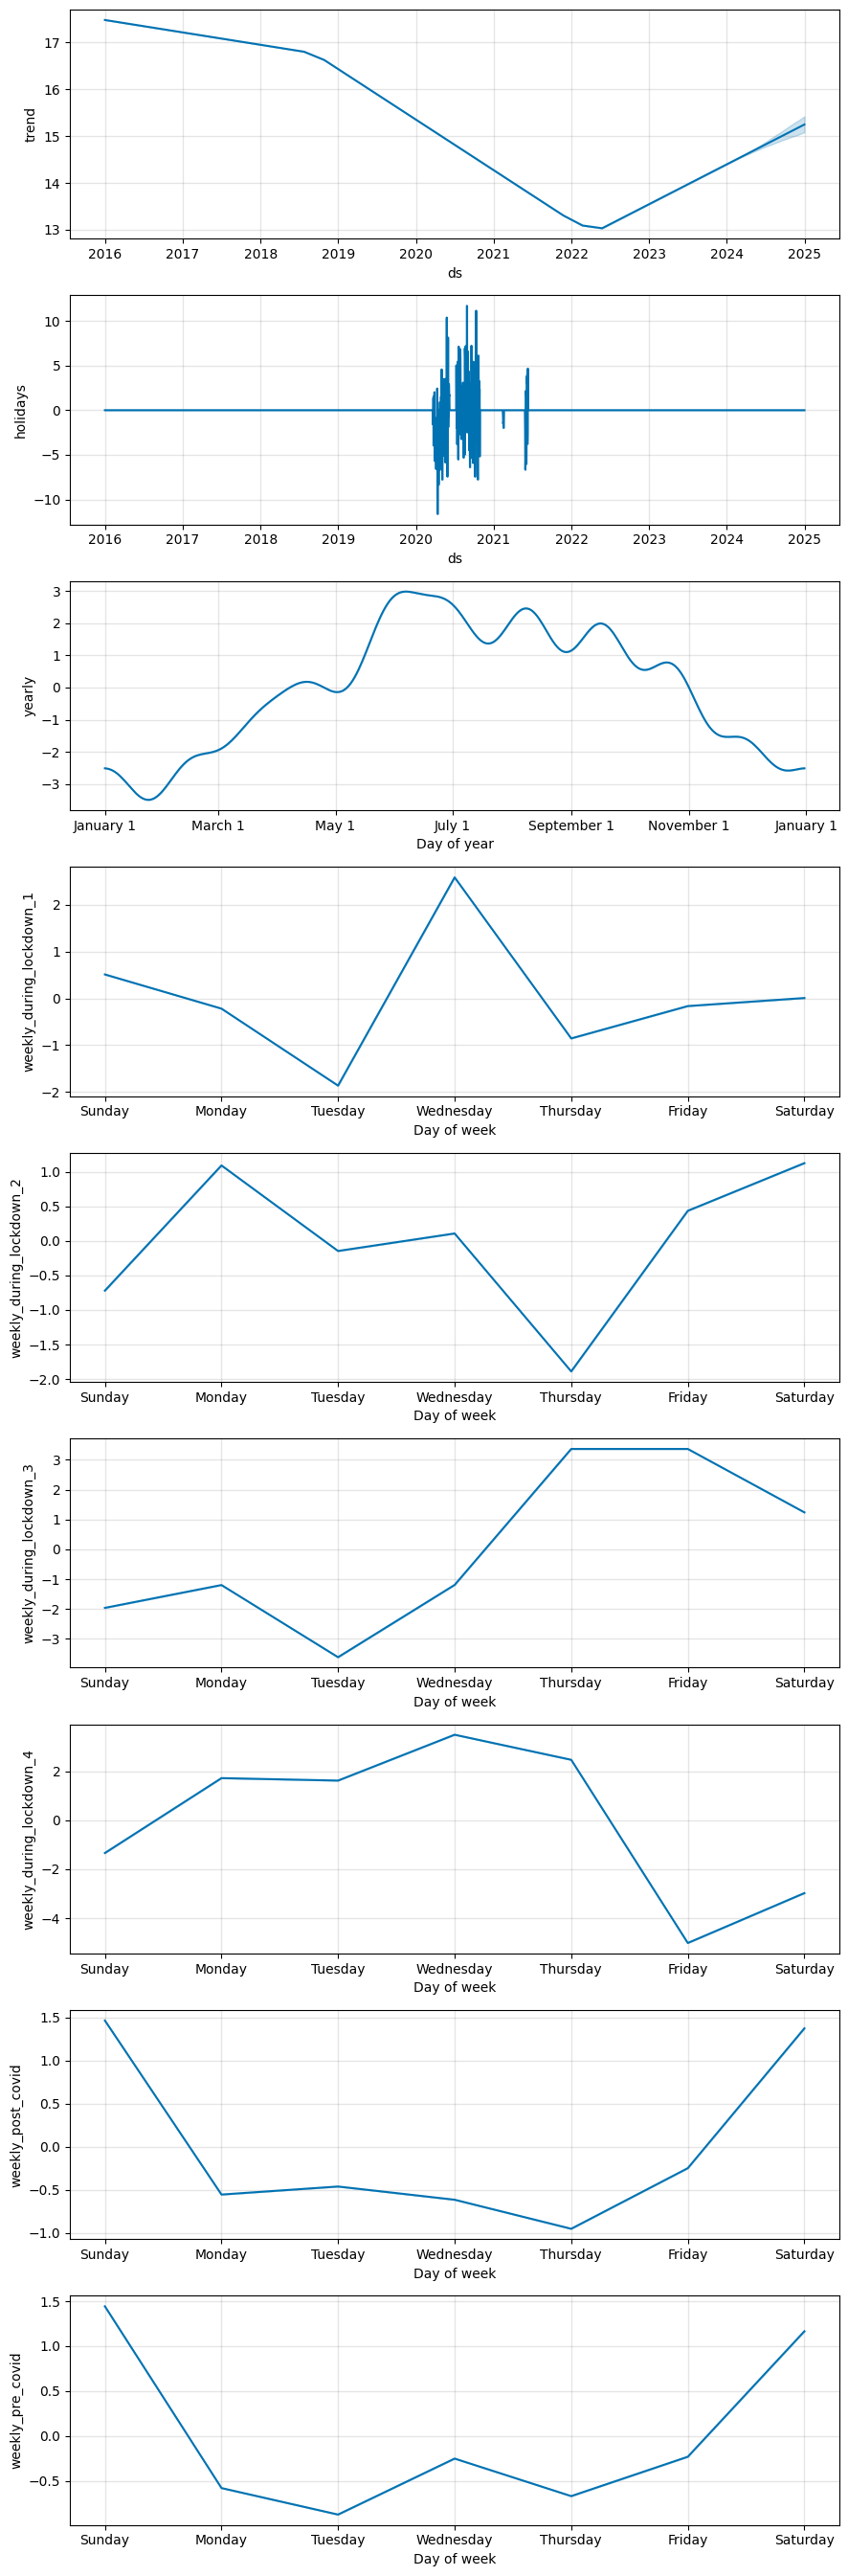

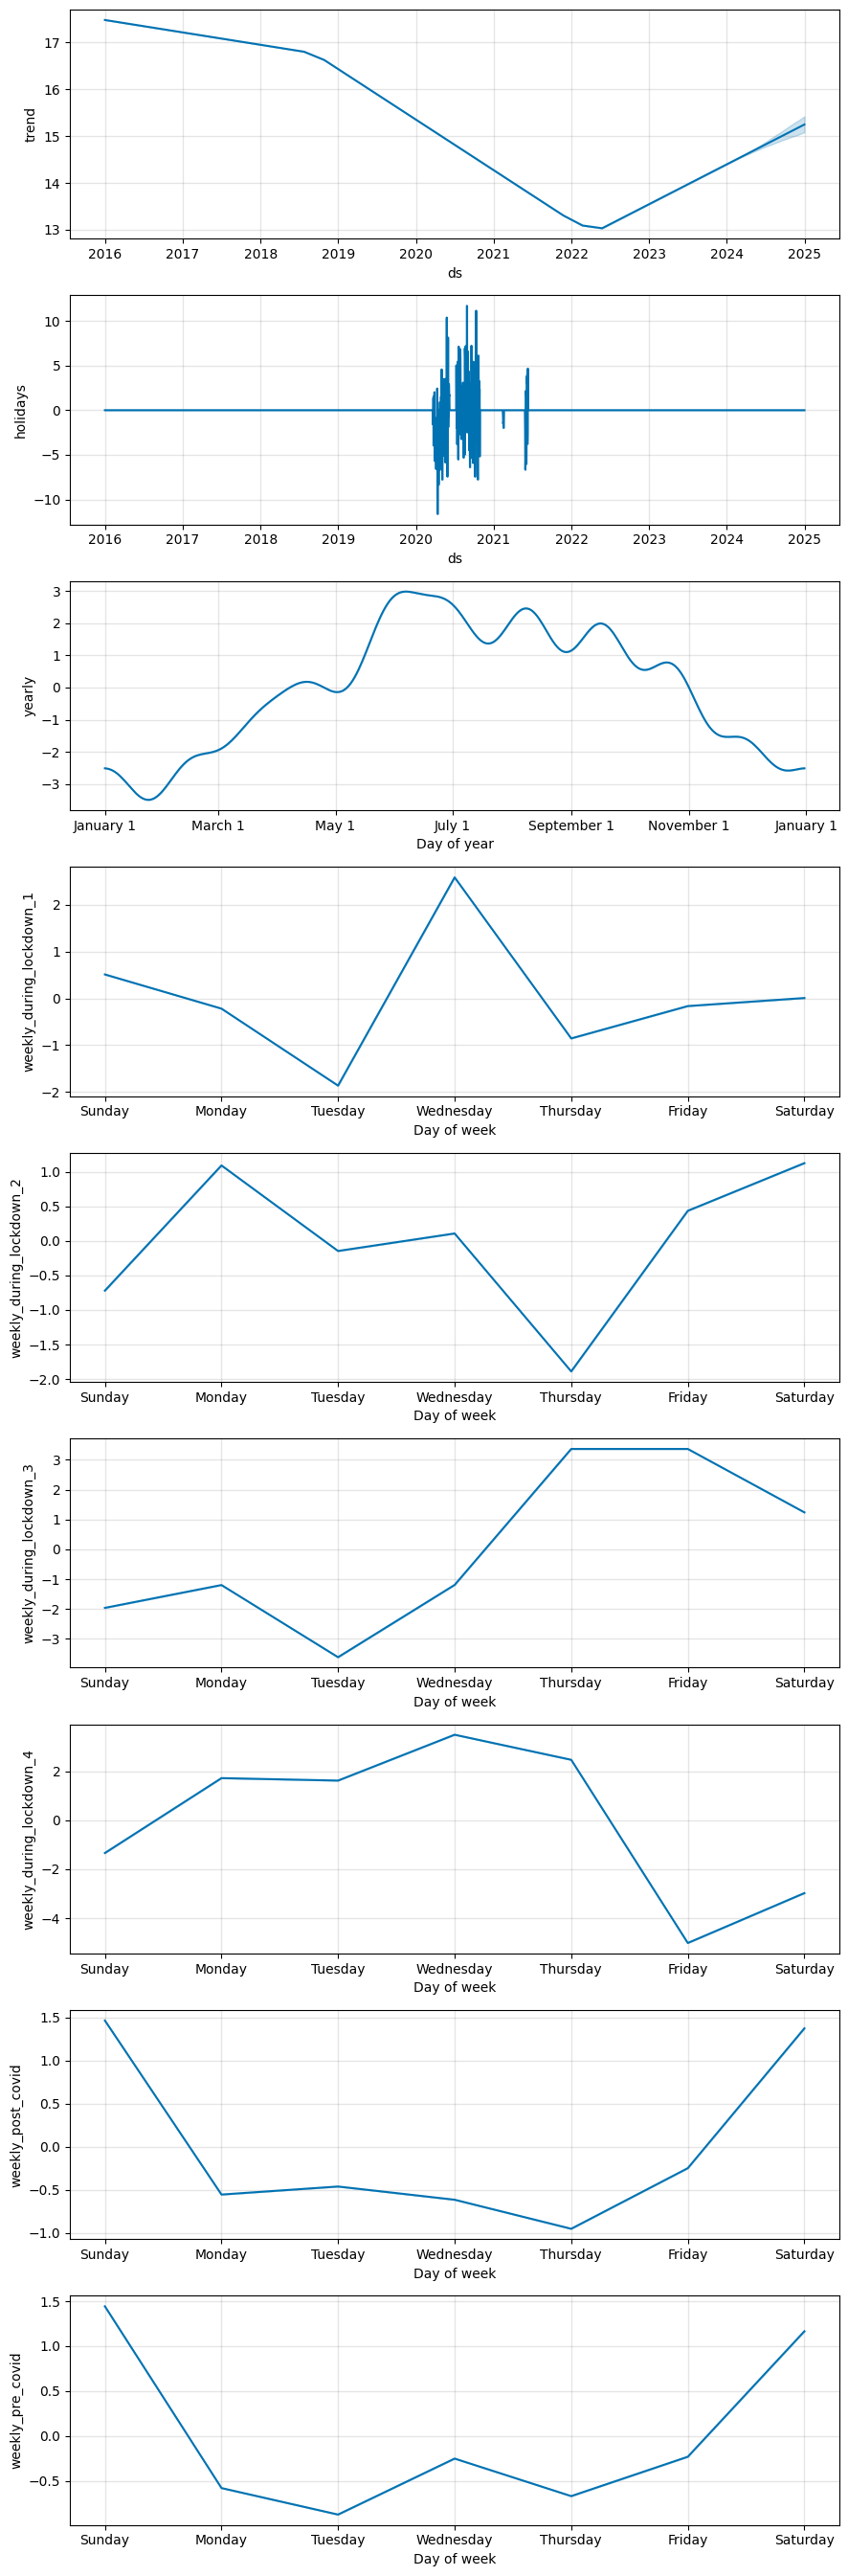

In [642]:
m4.plot_components(forecast4)

In [643]:
# Make a forecast_final joined with the original dataframe
forecast_final = forecast4.set_index('ds')[['yhat']].join(chicago_prophet_df_final.set_index('ds').y).reset_index()

# Remove NaN values in y
forecast_final.dropna(subset = ['y'], inplace = True)

# Calculate error and uncertainty
forecast_final['error'] = forecast_final['y'] - forecast_final['yhat']
forecast_final['uncertainty'] = forecast_final['yhat']

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(forecast_final['yhat'],forecast_final['y'])
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = sqrt(int(mean_squared_error(forecast_final['yhat'],forecast_final['y'])))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

Mean Absolute Error (MAE): 3.12
Median Absolute Error (MedAE): 2.56
Mean Squared Error (MSE): 16.54
Root Mean Squared Error (RMSE): 4.0
Mean Absolute Percentage Error (MAPE): 0.21 %


In [644]:
# Anomalies
import plotly.express as px
# Find the anomalies using prediction error and uncertainty, create anomaly column yes and no
test_df = chicago_prophet_df_final.copy()
forecasted = forecast4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecasted = forecasted.set_index('ds')
test_df = test_df.set_index('ds')
joined = test_df.join(forecasted, how='outer')
joined['error'] = joined['y'] - joined['yhat']
joined['uncertainty'] = joined['yhat_upper'] - joined['yhat_lower']

# This factor can be customized based on the data
factor = 1.5
joined['anomaly'] = joined.apply(lambda x: 'Yes' 
      if(np.abs(x['error']) >  factor*x['uncertainty']) else 'No', axis = 1)

joined.reset_index(inplace=True)

color_discrete_map = {'Yes': 'rgb(255,12,0)', 'No': 'blue'}
fig = px.scatter(joined, x='ds', y='y', color='anomaly', color_discrete_map=color_discrete_map)
fig.show()

In [645]:
# Plot a shap
from prophet.plot import plot_components_plotly
fig = plot_components_plotly(m4, forecast4)
fig.show()

# Full Moon And George Floyd

In [646]:
full_moon_df = pd.read_csv("full_moon.csv")
# Change FullMoonDates to Dates and make it the same format as the other dataframes
full_moon_df.rename(columns = {'FullMoonDates':'ds'}, inplace = True)
full_moon_df['ds'] = pd.to_datetime(full_moon_df['ds'])

In [647]:
full_moon_df.head()

Year         ds
0  2005 2005-01-25
1  2005 2005-02-24
2  2005 2005-03-25
3  2005 2005-04-24
4  2005 2005-05-23

In [662]:
# Create m5 and add in when the full moon is
m5 = Prophet(holidays=lockdowns, weekly_seasonality=False)

m5.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m5.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
)
m5.add_seasonality(
    name='weekly_during_lockdown_1',
    period=7,
    fourier_order=3,
    condition_name='during_lockdown_1',
)
m5.add_seasonality(
    name='weekly_during_lockdown_2',
    period=7,
    fourier_order=3,
    condition_name='during_lockdown_2',
)
m5.add_seasonality(
    name='weekly_during_lockdown_3',
    period=7,
    fourier_order=3,
    condition_name='during_lockdown_3',
)
m5.add_seasonality(
    name='weekly_during_lockdown_4',
    period=7,
    fourier_order=3,
    condition_name='during_lockdown_4',
)
# Add in the full moon
m5.add_regressor('full_moon')

m5.add_country_holidays(country_name='US')

# add seasonality for george floyd protests
m5.add_seasonality(name='protests', period=7, fourier_order=3, condition_name='protests')

In [663]:
df3 = df2.copy()
# If full moon is in the date, set it to True
df3['full_moon'] = df3['ds'].isin(full_moon_df['ds'])
# Protests, May 28 – August 10, 2020, May 20–21, 2012, March 11, 2016	
df3['george_floyd_protests'] = (pd.to_datetime(df3['ds']) >= pd.to_datetime('2020-05-28')) & (pd.to_datetime(df3['ds']) <= pd.to_datetime('2020-08-10'))
df3.head()

ds   y  pre_covid  post_covid  during_lockdown_1  \
5478 2016-01-01  27       True       False              False   
5479 2016-01-02  10       True       False              False   
5480 2016-01-03  17       True       False              False   
5481 2016-01-04  10       True       False              False   
5482 2016-01-05  16       True       False              False   

      during_lockdown_2  during_lockdown_3  during_lockdown_4  full_moon  \
5478              False              False              False      False   
5479              False              False              False      False   
5480              False              False              False      False   
5481              False              False              False      False   
5482              False              False              False      False   

      protests  
5478     False  
5479     False  
5480     False  
5481     False  
5482     False

In [664]:
m5 = m5.fit(df3)

02:31:01 - cmdstanpy - INFO - Chain [1] start processing
02:31:03 - cmdstanpy - INFO - Chain [1] done processing


In [665]:
future5 = m5.make_future_dataframe(periods=365)
future5['pre_covid'] = pd.to_datetime(future5['ds']) < pd.to_datetime('2020-03-21')
future5['post_covid'] = ~future5['pre_covid']
future5['during_lockdown_1'] = (pd.to_datetime(future5['ds']) >= pd.to_datetime('2020-03-21')) & (pd.to_datetime(future5['ds']) <= pd.to_datetime('2020-06-06'))
future5['during_lockdown_2'] = (pd.to_datetime(future5['ds']) >= pd.to_datetime('2020-07-09')) & (pd.to_datetime(future5['ds']) <= pd.to_datetime('2020-10-27'))
future5['during_lockdown_3'] = (pd.to_datetime(future5['ds']) >= pd.to_datetime('2021-02-13')) & (pd.to_datetime(future5['ds']) <= pd.to_datetime('2021-02-17'))
future5['during_lockdown_4'] = (pd.to_datetime(future5['ds']) >= pd.to_datetime('2021-05-28')) & (pd.to_datetime(future5['ds']) <= pd.to_datetime('2021-06-10'))
future5['full_moon'] = future5['ds'].isin(full_moon_df['ds'])
future5['george_floyd_protests'] = (pd.to_datetime(future5['ds']) >= pd.to_datetime('2020-05-28')) & (pd.to_datetime(future5['ds']) <= pd.to_datetime('2020-08-10'))

In [666]:
forecast5 = m5.predict(future5)

Text(0.5, 1.0, 'Lockdowns as one-off holidays + Conditional weekly seasonality')

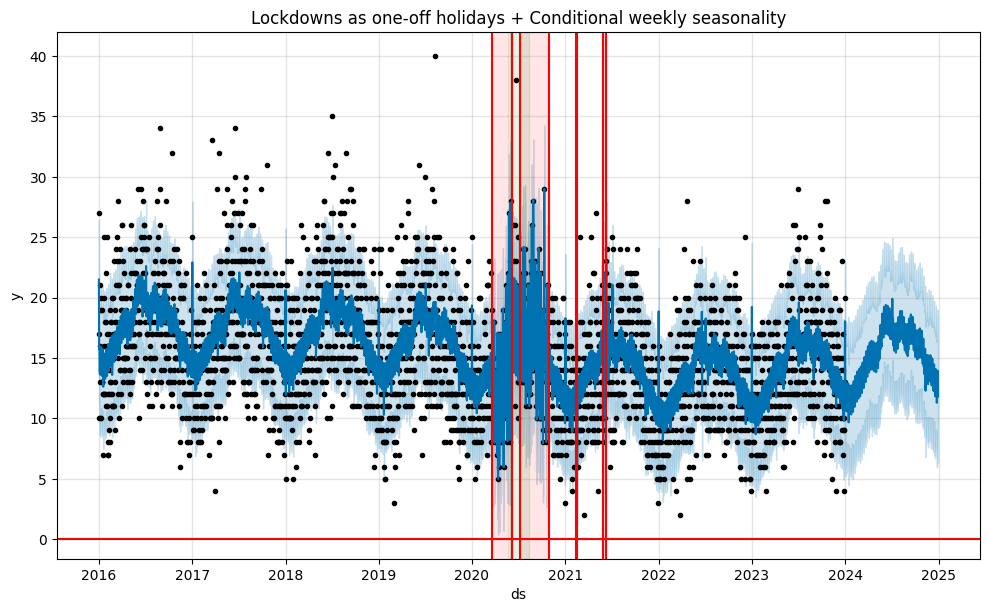

In [669]:
m5.plot(forecast5)
plt.axhline(y=0, color='red')
# Add Pre Covid line
plt.axvline(x=pd.to_datetime('2020-03-21'), color='red')
# Add Post Covid line
plt.axvline(x=pd.to_datetime('2020-06-06'), color='red')
# Add Lockdown 2 line
plt.axvline(x=pd.to_datetime('2020-07-09'), color='red')
# Add Lockdown 3 line
plt.axvline(x=pd.to_datetime('2020-10-27'), color='red')
# Add Lockdown 4 line
plt.axvline(x=pd.to_datetime('2021-02-13'), color='red')
# Add lockdown 5 line
plt.axvline(x=pd.to_datetime('2021-02-17'), color='red')
# Add lockdown 6 line
plt.axvline(x=pd.to_datetime('2021-05-28'), color='red')
# Add lockdown 7 line
plt.axvline(x=pd.to_datetime('2021-06-10'), color='red')
# Shade in between each
plt.axvspan(pd.to_datetime('2020-03-21'), pd.to_datetime('2020-06-06'), color='red', alpha=0.1)
plt.axvspan(pd.to_datetime('2020-07-09'), pd.to_datetime('2020-10-27'), color='red', alpha=0.1)
plt.axvspan(pd.to_datetime('2021-02-13'), pd.to_datetime('2021-02-17'), color='red', alpha=0.1)
plt.axvspan(pd.to_datetime('2021-05-28'), pd.to_datetime('2021-06-10'), color='red', alpha=0.1)
# Add George Floyd Protests line
plt.axvline(x=pd.to_datetime('2020-05-28'), color='green')
# Add George Floyd Protests line
plt.axvline(x=pd.to_datetime('2020-08-10'), color='green')
# Shade in between each
plt.axvspan(pd.to_datetime('2020-05-28'), pd.to_datetime('2020-08-10'), color='green', alpha=0.1)
plt.title('Lockdowns as one-off holidays + Conditional weekly seasonality')

In [672]:
fig = plot_components_plotly(m5, forecast5)
fig.show()

In [671]:
# Make a forecast_final joined with the original dataframe
forecast_final = forecast5.set_index('ds')[['yhat']].join(chicago_prophet_df_final.set_index('ds').y).reset_index()

# Remove NaN values in y
forecast_final.dropna(subset = ['y'], inplace = True)

# Calculate error and uncertainty
forecast_final['error'] = forecast_final['y'] - forecast_final['yhat']
forecast_final['uncertainty'] = forecast_final['yhat']

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(forecast_final['yhat'],forecast_final['y'])
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = sqrt(int(mean_squared_error(forecast_final['yhat'],forecast_final['y'])))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(forecast_final['yhat'],forecast_final['y'])
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

Mean Absolute Error (MAE): 3.09
Median Absolute Error (MedAE): 2.57
Mean Squared Error (MSE): 16.21
Root Mean Squared Error (RMSE): 4.0
Mean Absolute Percentage Error (MAPE): 0.21 %
